In [1]:
# !pip install tesseract
# !pip install pytesseract

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

### Read Image

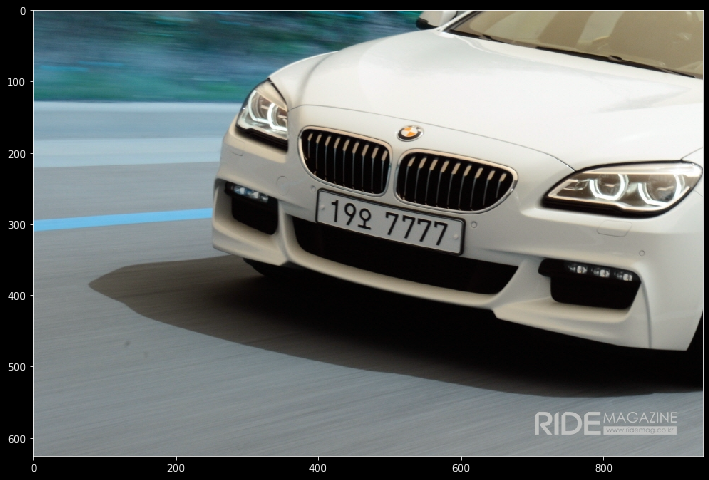

In [6]:
img_ori = cv2.imread('Data/1.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

### Convert Grayscale

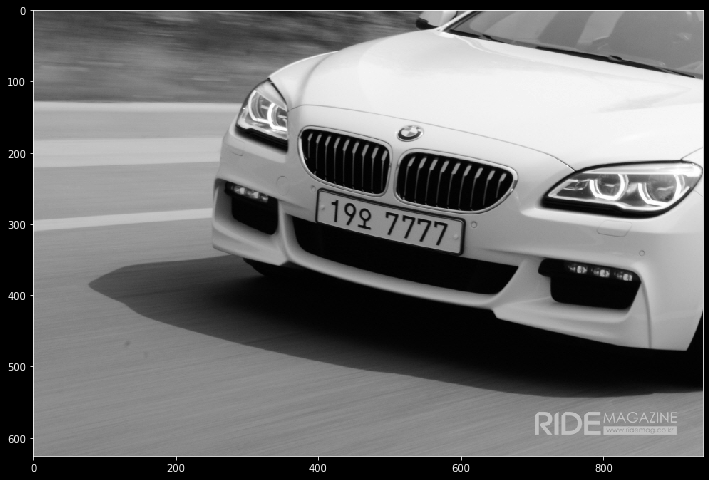

In [7]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

### Adaptive Thresholding

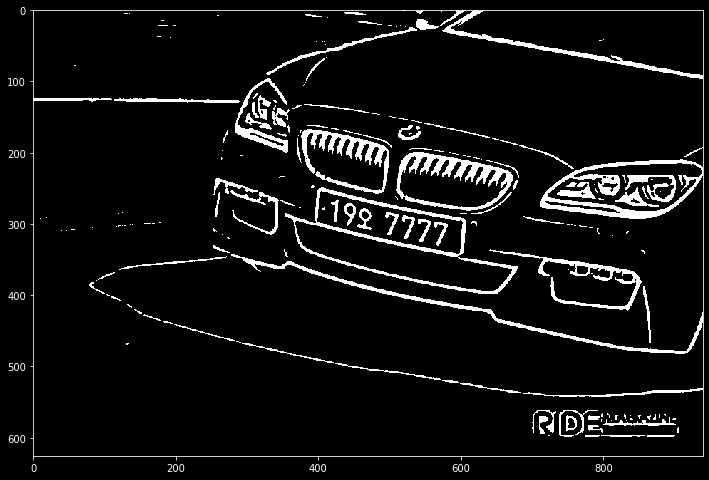

In [8]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) # 노이즈를 줄이기 위해 Gaussian Blur 사용.

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)
# adaptive threshold_이미지를 구별하기 쉽도록 설정한 값보다 낮은 값은 0으로, 높은 값은 255로 처리.
plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

### Find Contours

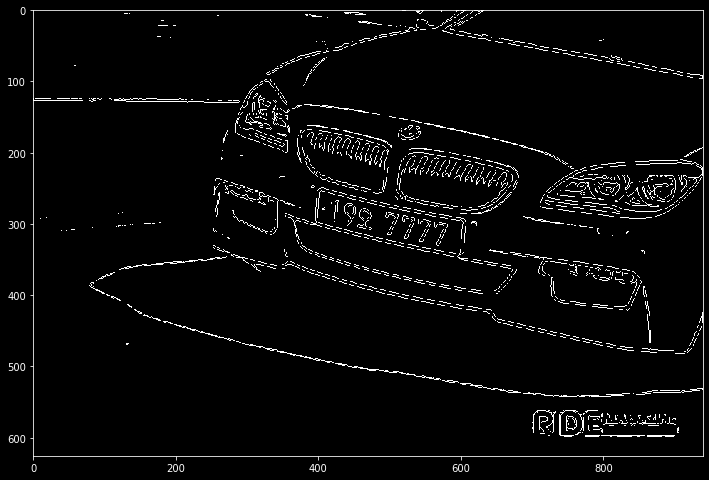

In [9]:
contours, _ = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
# cv2.findContours()_이미지에서 윤곽선 찾기. 이전 openCV 버전은 findContour함수가 리턴값이 3개였으나, 4.x 부터는 리턴값이 두 개로 바뀜.(contour 배열은 0번째로 리턴되기 때문에 contours, _로.)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255)) # 윤곽선 그리기.

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

### Prepare Data

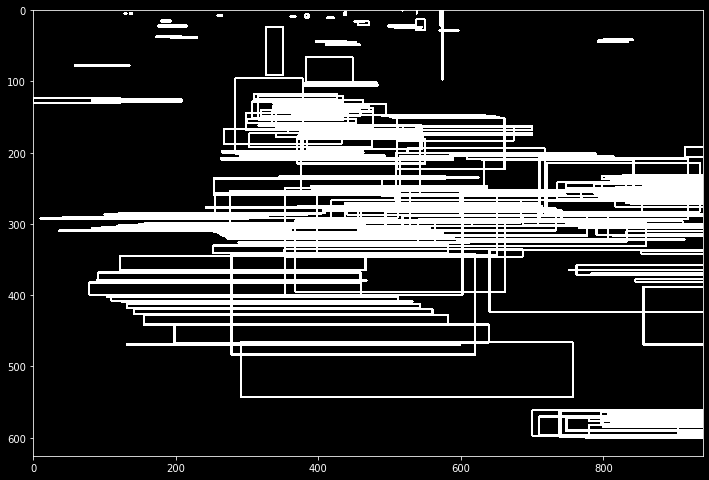

In [10]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) # cv2.boundingRect()_윤곽선을 감싸는 사각형을 구함.
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+y, y+h), color=(255, 255, 255), thickness=2) # 이미지에 사각형 그리기.

    contours_dict.append({
        'contour':contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x + (w / 2),
        'cy':y + (h / 2) # cx, cy는 boundingRect를 이용해 구한 사각형의 중심 좌표.
    })
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

### Select Candidates by Char Size

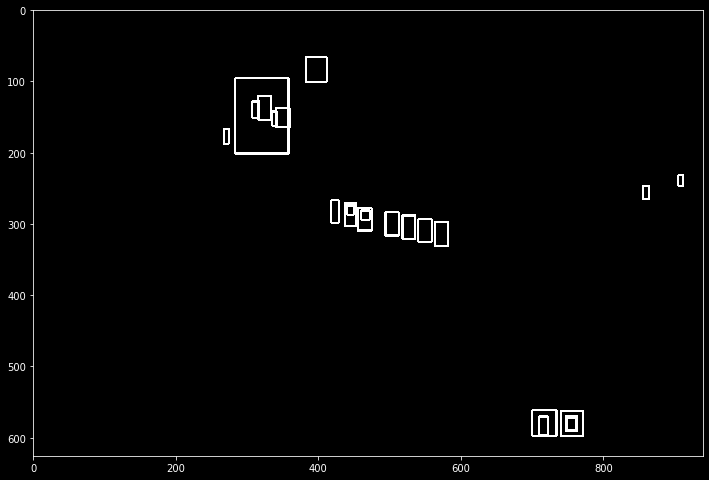

In [11]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0
# 번호판의 크기를 찾기 위해 대략의 값을 지정.

possible_contours = [] # 가능성이 있는 모든 것들을 저장.

cnt = 0
for d in contours_dict: # contours_dict를 돌면서 넓이랑 비율을 계산해 적합한 것들을 찾음.
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d) # 각 윤곽선의 idx값을 같이 저장. 나중에 idx로 확인.

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

### Select Candidates by Arrangement of Contours

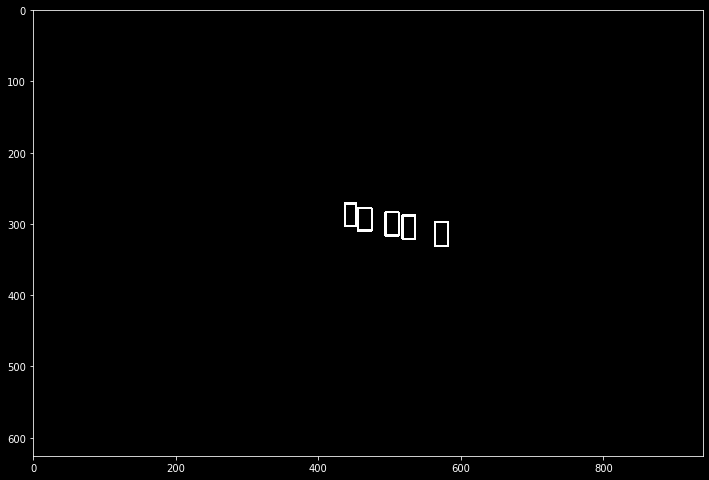

In [12]:
MAX_DIAG_MULTIPLYER = 5 # contour와 contour 사이의 길이 제한. 첫번째 contour의 대각선 길이의 5배 안에 있어야 한다는 조건.
MAX_ANGLE_DIFF = 12.0 # contour와 contour 사이의 각 중심을 이어 직각 삼각형을 만들었을 때, 그 각의 최대 각을 제한.
MAX_AREA_DIFF = 0.5 # contour와 contour 간의 면적 차이를 제한.
MAX_WIDTH_DIFF = 0.8 # contour와 contour 간의 너비 차이를 제한.
MAX_HEIGHT_DIFF = 0.2 # contour와 contour 간의 높이 차이를 제한.
MIN_N_MATCHED = 3 # 위의 조건을 만족하는 contour들이 최소 3개 이상이 되도록 제한.

def find_chars(contour_list): # 나중에 Recursive(재귀) 방식으로 반복해서 번호판 후보군을 찾을 수 있도록.
    matched_result_idx = [] # 최종 결과값의 idx값 저장.

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
    # for문을 2번 돌면서 contour d1과 다른 contour d2를 비교. 만약 d1과 d2가 같다면 continue를 사용해 넘김.

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            # d1과 d2 각각의 중심점 사이의 거리를 구하기 위해 dx와 dy를 계산.

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # d1의 대각선 길이.

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])) # np.linalg.norm(a - b)_벡터 a와 벡터 b 사이의 거리를 구함.
            if dx == 0: # dx가 0이라는 뜻은 contour와 contour 간의 x값 좌표가 같다는 것을 의미. 즉, 직각인 상황.
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # np.arctan()_아크탄젠트 값을 구함.(라디안.) np.degrees()_라디안을 각도로 변경.
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) # 면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                # 이전에 설정한 기준값들에 맞는 값들만 mathced_contours_idx 리스트에 idx값만 보냄.

        # append d1 contour.
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue 
        # 번호판 후보군의 윤곽선 개수가 3보다 작으면 번호판일 확륙이 낮음. 번호판의 개수는 그보다 많기 때문. 그래서 continue를 이용해 제외.

        matched_result_idx.append(matched_contours_idx) # 최종 통과한 번호판을 matched_result_idx에 보냄.

        unmatched_contour_idx = [] # 최종 통과하지 않은 것들을 한 번 더 확인하기 위한 작업을 위해 빈 리스트 작성.
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx) # np.take(a, idx)_a에서 idx와 같은 인덱스의 값만 추출함.

        # recursive
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

### Rotate Image

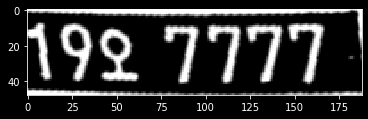

In [13]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx']) # x방향에 순차적으로 정렬.

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    # plate의 센터 x, y 좌표를 계산.

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0) # cv2.getRotationMatrix2D()_로테이션 매트릭스 구하기.

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height)) # cv2.warpAffine()_이미지 변형.

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    ) # cv2.getRectSubPix()_회전된 이미지에서 원하는 부분만 잘라냄.

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

### Another Thresholding to find chars

19오7777


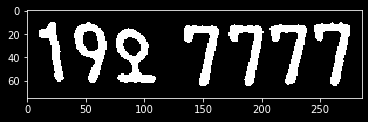

In [16]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # cv2.threshold()_쓰레시홀딩. 이미 한 번 쓰레시홀딩을 한 이미지이므로 간단한 cv2.THRESH_OTSU 사용.

    # find contours again
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h

    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    # tesseract를 사용하여 번호판을 인식하기 전, GaussianBlur를 이용하여 좀 더 노이즈를 제거하고 한 번 더 threshold를 함.
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    # cv2.copyMakeBorder()_이미지에 패딩을 준다. 이미지에 검은색으로 패딩하여 tesseract가 잘 인식할 수 있도록 한다.

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    # pytesseract.image_to_string()_이미지에서 글자를 읽음. 
    # '--psm 7'은 이미지 안에 글자가 한 줄로 놓여있다는 조건, '--oem 0'은 tesseract의 여러 버전의 모델 중 가장 초기 모델을 사용하겠다는 것.(번호판은 문맥을 파악하는 등의 인공지능 기술이 더해진 모델은 필요치 않음.)

    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit(): # 숫자나 한글이 포함되어 있는지를 확인.
            if c.isdigit():
                has_digit = True # 숫자가 하나라도 있는지를 확인.
            result_chars += c

    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

### Result

19오7777


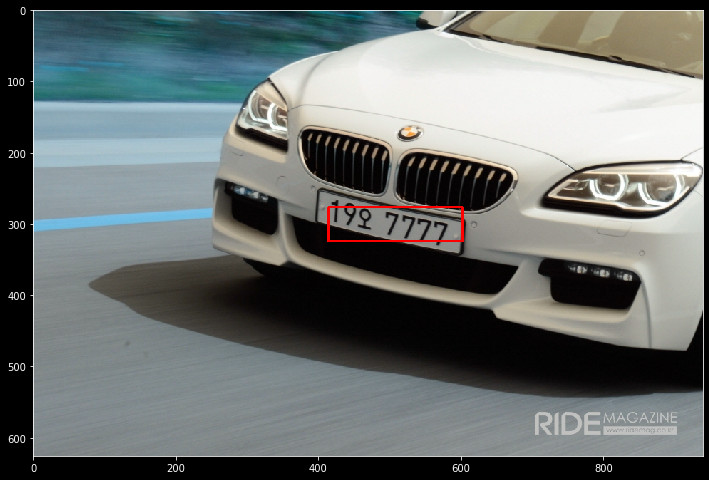

In [18]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x'] + info['w'], info['y'] + info['h']), color=(255,0, 0), thickness = 2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)